In [1]:
#importing libraries 
import numpy as np
import matplotlib.pyplot as plt
import os

from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers

from tensorflow.keras.applications import resnet50


In [2]:
main_folder = 'OCT2017/train'
class_names = os.listdir(main_folder)
print(class_names)

['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [3]:
#preparing training data images
x_train = [] #store the array of train images
y_train = [] #store the arrays labels

for folder in os.listdir(main_folder):
    image_list = os.listdir(main_folder+'/'+folder)
    for img_name in image_list:
        img = image.load_img(main_folder+'/'+folder+'/'+img_name, target_size=(100,100))
        # converting images to arrays of rgb values
        img=image.img_to_array(img)
        
        # to preprocess images before passing to resnet
        img = resnet50.preprocess_input(img)
        
        # adding image matrix to the input image matrix - x
        x_train.append(img)
        y_train.append(class_names.index(folder)) # adding label to the label matrix - y


In [4]:
# preparing testing dataset
test_folder = 'OCT2017/test'
x_test = []
y_test = []
for labels in os.listdir(test_folder):
    for testimg in os.listdir(test_folder+'/'+labels):
        test_images = image.load_img(test_folder+'/'+labels+'/'+testimg,  target_size=(100,100))
        test_images =image.img_to_array(test_images)
        test_images = resnet50.preprocess_input(test_images)
        x_test.append(test_images)
        y_test.append(class_names.index(labels))
        

In [5]:
x_test = np.array(x_test) # converting x_test to numpy array
y_test = to_categorical(y_test) # one hot encoding for the labels

In [6]:
x_train = np.array(x_train) #converting x_train to numpy array
y_train = to_categorical(y_train)# one hot encoding for the labels

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=0)
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)
print(x_test.shape)
print(y_test.shape)

(75135, 100, 100, 3)
(8349, 100, 100, 3)
(75135, 4)
(8349, 4)
(1000, 100, 100, 3)
(1000, 4)


In [8]:
# summary of default resnet50 structure
model_resnet = resnet50.ResNet50(weights='imagenet')
model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [9]:
# setting a new input layer to give different dimensions of parameters
input_layer = layers.Input(shape=(100,100,3))
model_resnet = resnet50.ResNet50(weights='imagenet',input_tensor=input_layer,include_top=False)

In [10]:
#flattening the last layer and adding a dense and one output layer at the end
last_layer = model_resnet.output
flatten = layers.Flatten()(last_layer)# last layer is flattened
output_layer = layers.Dense(4,activation = 'softmax')(flatten) # creating flattened output dense layer 
model = models.Model(inputs = input_layer, outputs = output_layer)

In [11]:
#freezing all the layers except the last , thus only the last layer will be trained
for layer in model.layers[:-1]:
    layer.trainable=False
    
# final model structure
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [12]:
# compiling the model 
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [14]:
# fitting the data into model
model.fit(X_train,Y_train,epochs=5,batch_size=64,verbose=True,validation_data=(X_val,Y_val))

Epoch 1/5
1174/1174 [==============================] - 3177s 3s/step - loss: 1.6081 - accuracy: 0.7483 - val_loss: 1.6954 - val_accuracy: 0.7415
Epoch 2/5
1174/1174 [==============================] - 3272s 3s/step - loss: 1.3594 - accuracy: 0.8063 - val_loss: 1.5772 - val_accuracy: 0.7911
Epoch 3/5
1174/1174 [==============================] - 3259s 3s/step - loss: 1.1958 - accuracy: 0.8339 - val_loss: 1.6615 - val_accuracy: 0.8209
Epoch 4/5
1174/1174 [==============================] - 3355s 3s/step - loss: 1.0274 - accuracy: 0.8548 - val_loss: 1.6787 - val_accuracy: 0.8136
Epoch 5/5
1174/1174 [==============================] - 3379s 3s/step - loss: 0.9994 - accuracy: 0.8639 - val_loss: 2.4589 - val_accuracy: 0.8063


In [15]:
def predict(img_name):
    prediction = model.predict(img_name.reshape(1,100,100,3))
    return(np.argmax(prediction))


In [47]:
output = []
for image_no in range(x_test.shape[0]) :
    output.append(predict(x_test[image_no]))

In [48]:
output = np.array(output).reshape(1000,1)

In [49]:
# finding true labels
test_folder = 'OCT2017/test'
true_labels = []
for label in os.listdir(test_folder):
    for img_number in os.listdir(test_folder+'/'+label):
        true_labels.append(class_names.index(label))
        

In [50]:
from sklearn.metrics import f1_score,accuracy_score
f1_score(true_labels,output, average=None)

array([0.7814992 , 0.84569138, 0.56160458, 0.90666667])

In [51]:
output = to_categorical(output)

In [56]:
from tensorflow.keras.metrics import Accuracy

In [57]:
acc = Accuracy()
acc.update_state(y_test,output)
acc.result().numpy()

0.896

In [58]:
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.cm as cm

In [154]:
# Now we will try to visualize some region of interest(ROI) in the images for the classification of images

In [148]:
last_conv_layer_name = "conv5_block3_out"
img_size = (100,100)


In [152]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
# First, we create a model that maps the input image to the activations of the last conv layer as well as the output predictions
     
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
# Then, we compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
# This is the gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer 
    grads = tape.gradient(class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    

    last_conv_layer_output = last_conv_layer_output[0]
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


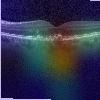

DRUSEN


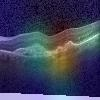

CNV


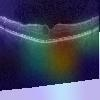

DME


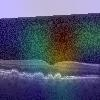

DRUSEN


In [153]:
model.layers[-1].activation = None  
def save_and_display_gradcam(img_array, heatmap, cam_path="cam.jpg", alpha=0.4):

    img = img_array
    # rescaling heatmap to a 255 pixels
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    

random = np.random.randint(1,x_test.shape[0]-10,size=(4,1))
np.array(true_labels)
true_labels = np.array(true_labels).reshape(1000,1)
for i in range(4):
    save_and_display_gradcam(x_test[i+random[i]].reshape(100,100,3), heatmap)
    print(class_names[np.ndarray.item(true_labels[i+random[i]])])